In [1]:
import json
import os 
import sys

import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import math

from myPackage.utils import show_image, kmeans_color_quantization, crop_image_white_background, euclidean_calculation, closest_point
from myPackage.utils import silhouette_analysis_of_kmeans_image_clustering, detect_SEM_scale_information, plot_top_two_quantized_images 
from myPackage.utils import show_histogram, remove_outliers, find_particle_size, elbow_analysis #Improve readability

from scipy.spatial import distance 
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
from skimage.io import imread 
from skimage.filters import threshold_multiotsu
from random import choice



In [2]:
%load_ext autoreload
%autoreload 2

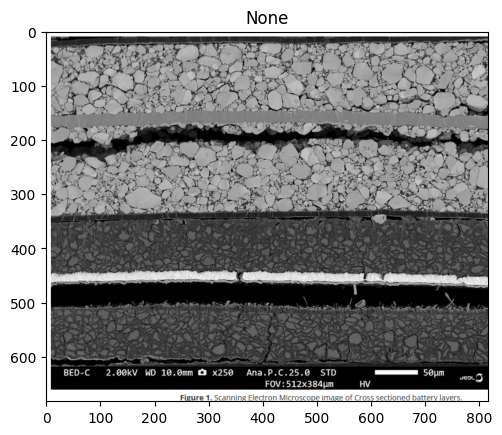

<Axes: title={'center': 'None'}>

In [3]:
#Load images
imageFile = 'cathodeXSection.png'
readImage = cv2.imread(imageFile)
original = readImage.copy()
analyzable_image = readImage[:330,:] #Needs a bit mo
new_original =analyzable_image.copy()
analyzable_image_containing_SEM_info = readImage[330:, :]
show_image(original)

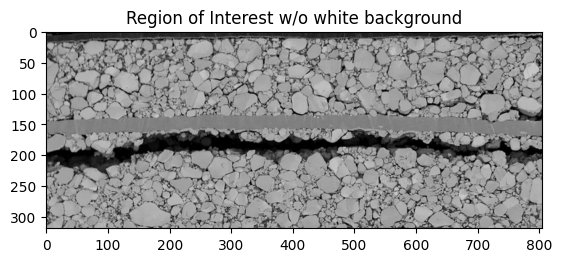

In [4]:
#We are interested in the cathode section of the image, get rid of white boundaries
analyzable_image = crop_image_white_background(analyzable_image)

x,y,w,h are (608, 53, 78, 3)


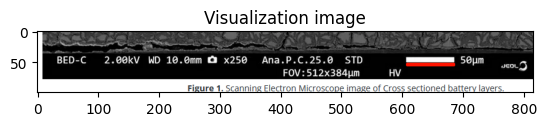

Scale Bar Detected: Width=78 pixels, Height=3 pixels
Scale length per pixel: 0.6410256410256411 um/pixel
Area per area pixel: 0.4109138724523341 um^2/pixel^2


In [5]:
#Still need the original image to gather information on length and area scale
length_per_pixel, area_per_pixel  = detect_SEM_scale_information(original)

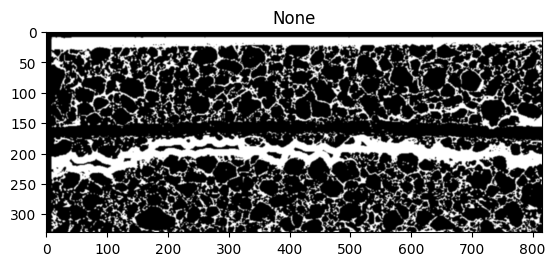

<Axes: title={'center': 'None'}>

In [51]:
#Use watershed algo to find individual particle sizes - Trial
kernel = np.ones((1,1), np.uint8)
opening = cv2.morphologyEx(new_result, cv2.MORPH_OPEN, kernel, iterations=2)

#Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

#Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255,0)

#Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

show_image(unknown)

In [ ]:
#Trying for particle counts and sizes again using kmeans method



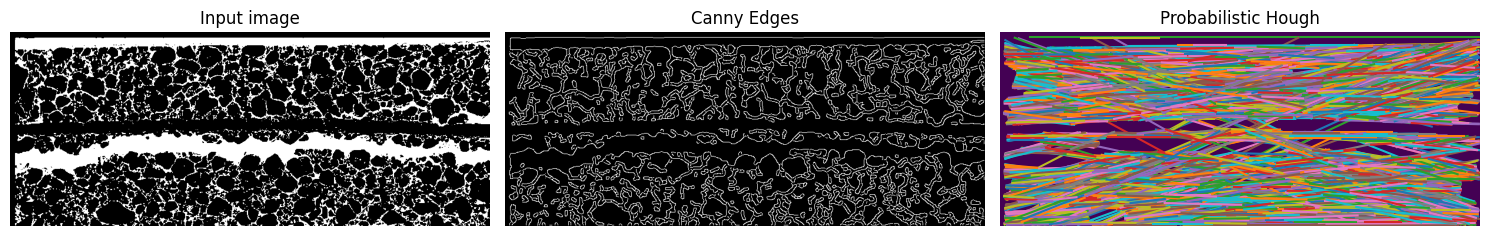

In [40]:
#Implementing line detecting 

# edges = canny(new_result, 4.5,1,125) #Have to use gray image here 

angleLow = math.radians(60)
angleHigh = math.radians(120)

edges = canny(new_result,2,1,131)

lines = probabilistic_hough_line(edges, threshold = 10,line_gap = 50, theta=np.arange(angleLow, angleHigh, 10**(-4)))



#Generating figure 2
fig,axes = plt.subplots(1,3,figsize = (15,5), sharex = True, sharey = True)
ax = axes.ravel()

ax[0].imshow(new_result[:,:], cmap = cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap = cm.gray)
ax[1].set_title('Canny Edges')

ax[2].imshow(edges * 0)



for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]),(p0[1], p1[1]))
ax[2].set_xlim((0,new_result.shape[1]))
ax[2].set_ylim((new_result.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()
plt.tight_layout()
plt.show()

(0.0, 256.0)

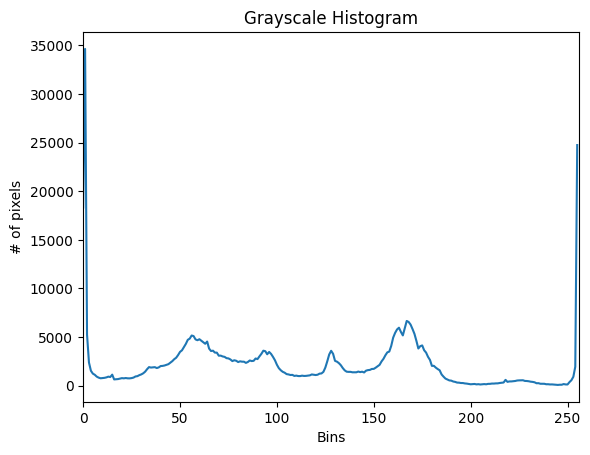

In [39]:
#Calculate histogram of this image

hist = cv2.calcHist([readImage], [0], None, [256], [0,256])
normalizeHist = hist/hist.sum() 


plt.figure()
plt.title('Grayscale Histogram')
plt.xlabel('Bins')
plt.ylabel('# of pixels')
plt.plot(hist)
plt.xlim([0,256])


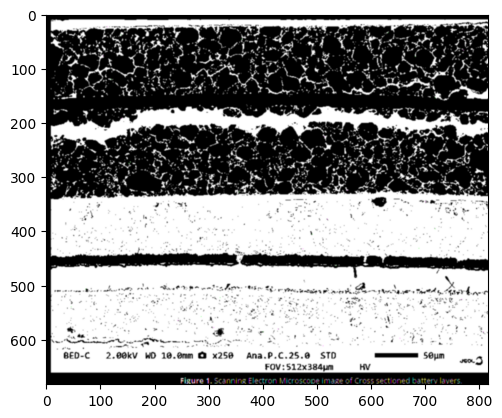

<Axes: >

In [37]:
#Highlighting the field based on grayscale values

threshold = 100
assignValue = 255
thresholdMethod = cv2.THRESH_BINARY_INV

_, result = cv2.threshold(readImage, threshold, assignValue, thresholdMethod)

showImage(result)